In [37]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [38]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [39]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [40]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

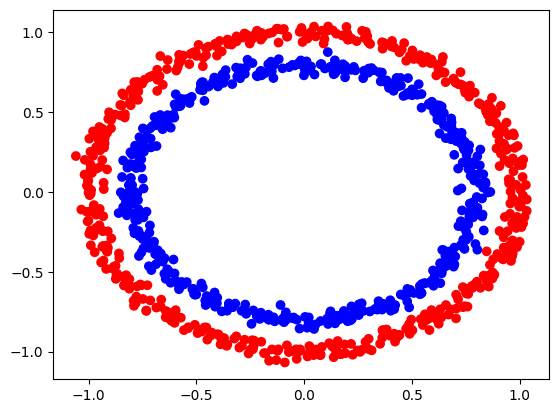

In [41]:
import matplotlib.pyplot as plt

colors = ['red' if label == 0 else 'blue' for label in y]
plt.scatter(x=X[:, 0],
            y = X[:, 1],
            color = colors)

In [42]:
X.shape, y.shape

((1000, 2), (1000,))

In [43]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [44]:
# Turn the data into pytorch tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [46]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [48]:
# We can do something similar with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0832],
        [ 0.2198],
        [-0.1694],
        [ 0.1543],
        [-0.0016],
        [ 0.0805],
        [ 0.3323],
        [ 0.3002],
        [-0.1761],
        [ 0.2309]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [50]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [51]:
# Let's define a function to calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates when two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [52]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0832],
        [ 0.2198],
        [-0.1694],
        [ 0.1543],
        [-0.0016]], device='cuda:0', grad_fn=<SliceBackward0>)

In [53]:
# Use sigmoid function on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5208],
        [0.5547],
        [0.4578],
        [0.5385],
        [0.4996]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [54]:
# Find the predicted label
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [55]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [56]:
# Let's make a training and testing loop
torch.manual_seed(42)

EPOCHS = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing the model
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69598, Accuracy: 51.25% | Test loss: 0.70382, Test acc: 46.50%
Epoch: 10 | Loss: 0.69506, Accuracy: 51.38% | Test loss: 0.70193, Test acc: 47.00%
Epoch: 20 | Loss: 0.69450, Accuracy: 50.88% | Test loss: 0.70061, Test acc: 47.50%
Epoch: 30 | Loss: 0.69412, Accuracy: 50.88% | Test loss: 0.69960, Test acc: 47.00%
Epoch: 40 | Loss: 0.69383, Accuracy: 50.88% | Test loss: 0.69880, Test acc: 47.00%
Epoch: 50 | Loss: 0.69362, Accuracy: 51.00% | Test loss: 0.69815, Test acc: 47.00%
Epoch: 60 | Loss: 0.69347, Accuracy: 50.75% | Test loss: 0.69761, Test acc: 47.50%
Epoch: 70 | Loss: 0.69335, Accuracy: 50.62% | Test loss: 0.69717, Test acc: 47.00%
Epoch: 80 | Loss: 0.69326, Accuracy: 51.12% | Test loss: 0.69680, Test acc: 46.50%
Epoch: 90 | Loss: 0.69319, Accuracy: 51.00% | Test loss: 0.69649, Test acc: 46.00%


In [59]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download
